In [1]:
#importing libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os, re
import string
import shutil
from wordcloud import WordCloud, STOPWORDS 

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Flatten,Embedding,Lambda,Dropout,LSTM,Conv1D,Concatenate,Add
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import keras.backend as K

#importing config, tokenizer & Roberta model here
from transformers import  RobertaConfig, TFRobertaModel
from tokenizers import ByteLevelBPETokenizer

In [2]:
#Loading the train dataset

train = pd.read_csv('train.csv')
print('The shape of a train dataset is :', train.shape)
train.head()

The shape of a train dataset is : (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
#Loading the test dataset
test = pd.read_csv('test.csv')
print('The shape of a test dataset is ', test.shape)
test.head()

The shape of a test dataset is  (3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [4]:
#Checking for null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
#dropping the rows with null values
train.dropna(inplace = True)
train.reset_index(inplace = True, drop = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
#downloading the vocab and merge file for the tokenizer
!wget "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json"
!wget "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt"

###Sentiment Extraction using Bert
After going through the  resources, I decided to use Bert for the task. The normal Question Answering tasks typically have the following format:

A Question
A Reference text which contains the answers
Here is an example from the famous SQuAD dataset:

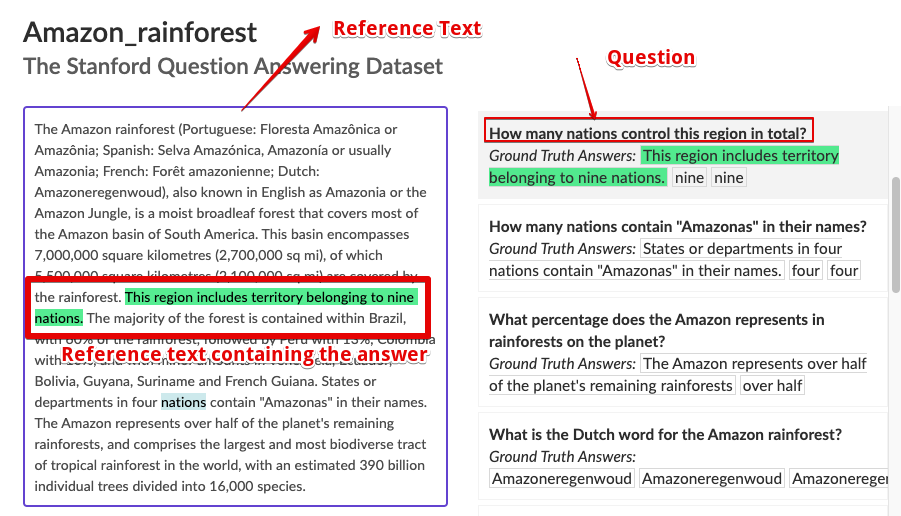

Hence, here the problem statement can also be converted to the QA task wherein we have:

* Question ==> Sentiment-column
* Reference Text ==> Text-column
* Answer ==> Selected Text-column

In [8]:
#setting up the global variables
MAX_LEN = 128
tokenizer = ByteLevelBPETokenizer(vocab = 'roberta-base-vocab.json', merges = 'roberta-base-merges.txt', lowercase = True,
                                  add_prefix_space = True)

#setting up a sentiment type dictionary with its token values

sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [9]:
#perform train, validation and test datset split

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train, train['sentiment'],
                                                  test_size = 0.2, random_state = 42, stratify = train['sentiment'])

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, 
                                                    test_size = 0.2, random_state = 42, stratify = X_train['sentiment'])

#resetting X index
X_train.reset_index(inplace = True, drop = True)
X_val.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)


#resetting Y index
Y_train = Y_train.reset_index(drop = True)
Y_val = Y_val.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

print('X_train shape:', X_train.shape, ' Y_train shape:', Y_train.shape)
print('X_val shape  :', X_val.shape, ' Y_val shape    :', Y_val.shape)
print('X_test shape :', X_test.shape, ' Y_test shape  :', Y_test.shape)

X_train shape: (17587, 4)  Y_train shape: (17587,)
X_val shape  : (5496, 4)  Y_val shape    : (5496,)
X_test shape : (4397, 4)  Y_test shape  : (4397,)


In [10]:
# defining input data function
def createInputData(data, tokenizer):

  row = data.shape[0]
  input_ids = np.ones((row, MAX_LEN), dtype = 'int32')
  attention_mask = np.zeros((row, MAX_LEN), dtype = 'int32')
  token_type_ids = np.zeros((row, MAX_LEN), dtype = 'int32')
  start_tokens = np.zeros((row, MAX_LEN), dtype = 'int32')
  end_tokens = np.zeros((row, MAX_LEN), dtype = 'int32')

  for k in range(data.shape[0]):
      
    #finding the index for a selected-text in text
    text1 = " "+" ".join(data.loc[k, 'text'].split())
    text2 = " ".join(data.loc[k, 'selected_text'].split())
    idx = text1.find(text2)

    #setting the value with 1 where selected-text are present
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)] = 1

    if text1[idx-1] == ' ': 
      chars[idx-1] = 1 

    enc = tokenizer.encode(text1) 
        
    #offsets finder
    token_offsets = []
    idx = 0
    for i in enc.ids:
      word = tokenizer.decode([i])
      token_offsets.append((idx, idx+len(word)))
      idx+=len(word)
    
    
    #defining start and end tokens 
    target_idx = []
    for i,(o1, o2) in enumerate(token_offsets):
      if(sum(chars[o1:o2]) > 0):
        target_idx.append(i) 
        
    s_tok = sentiment_id[data.loc[k, 'sentiment']]

    input_ids[k, :len(enc.ids) + 5] = [0] + enc.ids + [2, 2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids) + 5] = 1

    #adding value 1 to account for [0]-token
    if len(target_idx) > 0:
      start_tokens[k, target_idx[0] + 1] = 1
      end_tokens[k, target_idx[-1] + 1] = 1

  return (input_ids, attention_mask, token_type_ids, start_tokens, end_tokens)

In [11]:
#convert train, validation and test data input to RoBERTA

X_tr1, X_tr2, X_tr3, Y_tr1, Y_tr2 = createInputData(X_train, tokenizer)
X_val1, X_val2, X_val3, Y_val1, Y_val2 = createInputData(X_val, tokenizer)
X_te1, X_te2, X_te3, Y_te1, Y_te2 = createInputData(X_test, tokenizer)

In [12]:
#checking shapes 

print('The shape of token ids      :', X_tr1.shape)
print('The shape of attention mask :', X_tr2.shape)
print('The shape of token type ids :', X_tr3.shape)
print('The shape of start tokens   :', Y_tr1.shape)
print('The shape of end tokens     :', Y_tr2.shape)

The shape of token ids      : (17587, 128)
The shape of attention mask : (17587, 128)
The shape of token type ids : (17587, 128)
The shape of start tokens   : (17587, 128)
The shape of end tokens     : (17587, 128)


In [13]:
#model Archietecture

def build_model():
  '''Builds the model'''

  ids = Input((MAX_LEN), name = 'ids', dtype = 'int32')
  att_mask = Input((MAX_LEN), name = 'att_mask', dtype = 'int32')
  type_ids = Input((MAX_LEN), name = 'type_ids', dtype = 'int32')

  roberta_conf = RobertaConfig.from_pretrained('roberta-base')
  roberta_model = TFRobertaModel.from_pretrained('roberta-base', config = roberta_conf)
  
  bert_output = roberta_model([ids, att_mask, type_ids])
  
  #first layer
  dropout1 = Dropout(0.1, name = 'dropout1')(bert_output[0])
  conv1d_1 = Conv1D(1, 1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 20), name = 'conv1d_1')(dropout1)
  flatten_1 = Flatten(name = 'flatten_1')(conv1d_1)
  flatten_1 = Dense(MAX_LEN)(flatten_1)
  out_1 = tf.keras.layers.Activation('softmax', name = 'activation1')(flatten_1)

  dropout2 = Dropout(0.1, name = 'dropout2')(bert_output[0])
  conv1d_2 = Conv1D(1, 1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 20), name = 'conv1d_2')(dropout2)
  flatten_2 = Flatten(name = 'flatten_2')(conv1d_2)
  flatten_2 = Dense(MAX_LEN)(flatten_2)
  out_2 = tf.keras.layers.Activation('softmax', name = 'activation2')(flatten_2)

  model1 = Model(inputs = [ids, att_mask, type_ids], outputs = [out_1, out_2])

  return model1
  
model1 = build_model()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [12]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ids (InputLayer)                [(None, 128)]        0                                            
__________________________________________________________________________________________________
att_mask (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
type_ids (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   ids[0][0]                        
                                                                 att_mask[0][0]               

Model Archietecture-
* Input Layer       : 3 input layers
* Input_ids         : Numeric ids of each token with value [1] as pad token
* Attention_mask    : It has 1 for tokens and 0 for others.
* Token_type ids    : It includes 0 for all as there are only one type.
* Roberta Model     : It returns a 768 dimensional-vector for each token.
* Conv1D            : 2 Conv1D layers, one for start & another for end scores. It has kernal size of 1 and 1 filter.
* OutputLayer       : Softmax activation applied to start and end scores

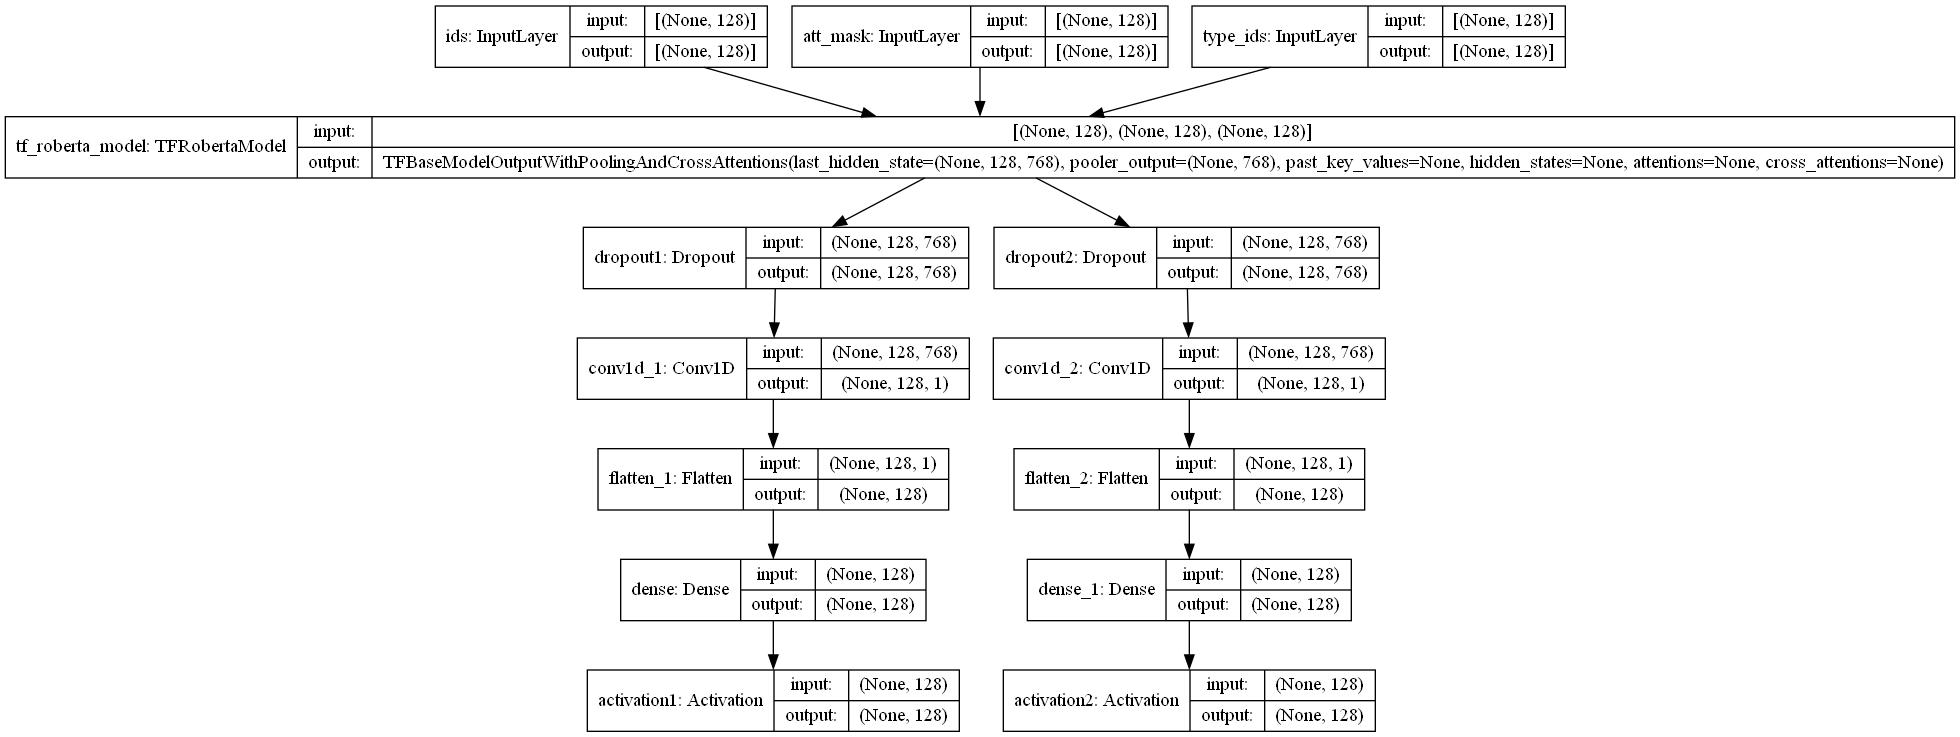

In [14]:
#model
tf.keras.utils.plot_model(model1, 'Model1.png', show_shapes = True)

In [ ]:
#creating  directory to save models

os.mkdir('Model1')
os.mkdir('model_save')

In [16]:
#setting up the parameters for TensorBoard

from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

!rm -rf ./logs/ 

log_dir = 'Model1'
tensorboard_callback = TensorBoard(log_dir = log_dir, histogram_freq = 1, write_graph = True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
#checkpoints to store the weights

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model_save/roberta.h5', monitor = 'val_loss', verbose = 1, save_best_only = True,
        save_weights_only = True, mode = 'auto', save_freq = 'epoch')

In [18]:
#model compilation

optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)
model1.compile(loss = 'categorical_crossentropy', optimizer = optimizer)

In [19]:
#fitting model

callback = [tensorboard_callback, checkpoint]
model1.fit([X_tr1, X_tr2, X_tr3], [Y_tr1, Y_tr2],
           validation_data = ([X_val1, X_val2, X_val3], [Y_val1, Y_val2]),
           batch_size = 32, epochs = 100, callbacks = callback, steps_per_epoch = 100, validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 86s 633ms/step - loss: 9.5756 - activation1_loss: 4.7674 - activation2_loss: 4.8082 - val_loss: 9.1086 - val_activation1_loss: 4.4815 - val_activation2_loss: 4.6270

Epoch 00001: val_loss improved from inf to 9.10857, saving model to model_save\roberta.h5
Epoch 2/100
100/100 [==============================] - 60s 600ms/step - loss: 8.2807 - activation1_loss: 3.7690 - activation2_loss: 4.5117 - val_loss: 7.1306 - val_activation1_loss: 2.9582 - val_activation2_loss: 4.1723

Epoch 00002: val_loss improved from 9.10857 to 7.13058, saving model to model_save\roberta.h5
Epoch 3/100
100/100 [==============================] - 60s 603ms/step - loss: 6.5662 - activation1_loss: 2.6789 - activation2_loss: 3.8873 - val_loss: 5.8672 - val_activation1_loss: 2.2932 - val_activation2_loss: 3.5739

Epoch 00003: val_loss improved from 7.13058 to 5.86719, saving model to model_save\roberta.h5
Epoch 4/100
100/100 [==============================] - 59s 


Epoch 00026: val_loss improved from 2.82526 to 2.81485, saving model to model_save\roberta.h5
Epoch 27/100
100/100 [==============================] - 57s 574ms/step - loss: 2.5620 - activation1_loss: 1.2964 - activation2_loss: 1.2656 - val_loss: 2.7928 - val_activation1_loss: 1.3352 - val_activation2_loss: 1.4576

Epoch 00027: val_loss improved from 2.81485 to 2.79279, saving model to model_save\roberta.h5
Epoch 28/100
100/100 [==============================] - 57s 573ms/step - loss: 2.4379 - activation1_loss: 1.2441 - activation2_loss: 1.1938 - val_loss: 2.8595 - val_activation1_loss: 1.3594 - val_activation2_loss: 1.5001

Epoch 00028: val_loss did not improve from 2.79279
Epoch 29/100
100/100 [==============================] - 58s 574ms/step - loss: 2.3876 - activation1_loss: 1.2217 - activation2_loss: 1.1659 - val_loss: 2.8940 - val_activation1_loss: 1.3452 - val_activation2_loss: 1.5488

Epoch 00029: val_loss did not improve from 2.79279
Epoch 30/100
100/100 [=====================

100/100 [==============================] - 64s 635ms/step - loss: 1.2544 - activation1_loss: 0.7224 - activation2_loss: 0.5320 - val_loss: 3.2523 - val_activation1_loss: 1.3916 - val_activation2_loss: 1.8608

Epoch 00056: val_loss did not improve from 2.68911
Epoch 57/100
100/100 [==============================] - 62s 622ms/step - loss: 1.2508 - activation1_loss: 0.7292 - activation2_loss: 0.5216 - val_loss: 3.2037 - val_activation1_loss: 1.4091 - val_activation2_loss: 1.7946

Epoch 00057: val_loss did not improve from 2.68911
Epoch 58/100
100/100 [==============================] - 62s 621ms/step - loss: 1.3305 - activation1_loss: 0.7456 - activation2_loss: 0.5849 - val_loss: 3.1451 - val_activation1_loss: 1.3611 - val_activation2_loss: 1.7840

Epoch 00058: val_loss did not improve from 2.68911
Epoch 59/100
100/100 [==============================] - 62s 622ms/step - loss: 1.3329 - activation1_loss: 0.7606 - activation2_loss: 0.5722 - val_loss: 3.2149 - val_activation1_loss: 1.4104 - va

100/100 [==============================] - 58s 583ms/step - loss: 0.5049 - activation1_loss: 0.3061 - activation2_loss: 0.1988 - val_loss: 4.3177 - val_activation1_loss: 1.9262 - val_activation2_loss: 2.3915

Epoch 00086: val_loss did not improve from 2.68911
Epoch 87/100
100/100 [==============================] - 59s 585ms/step - loss: 0.5560 - activation1_loss: 0.3371 - activation2_loss: 0.2189 - val_loss: 4.2711 - val_activation1_loss: 1.9308 - val_activation2_loss: 2.3402

Epoch 00087: val_loss did not improve from 2.68911
Epoch 88/100
100/100 [==============================] - 58s 575ms/step - loss: 0.5258 - activation1_loss: 0.3136 - activation2_loss: 0.2122 - val_loss: 4.2370 - val_activation1_loss: 1.9539 - val_activation2_loss: 2.2831

Epoch 00088: val_loss did not improve from 2.68911
Epoch 89/100
100/100 [==============================] - 58s 581ms/step - loss: 0.4228 - activation1_loss: 0.2390 - activation2_loss: 0.1838 - val_loss: 4.2869 - val_activation1_loss: 1.9502 - va

In [ ]:
#Loading the tensorboard

%tensorboard --logdir '/Model1'

In [22]:
model1.load_weights('model_save/roberta.h5')

In [23]:
#model prediction on hold out test dataset
start, end = model1.predict([X_te1, X_te2, X_te3])

In [24]:
#Jaccard score
def jaccard(str1, str2): 
    
  ''' Returns the jaccard score for the given two strings '''

  doc1 = set(str1.lower().split()) 
  doc2 = set(str2.lower().split())
  c = doc1.intersection(doc2)
  return float(len(c)) / (len(doc1) + len(doc2) - len(c))

In [25]:
def find_selected_text(data, tokenizer, start, end):
  '''finds the selected-text for a given tweet'''

  selected_text_list = []
  for i in range(data.shape[0]):

    #finds the start and end index
    
    start_idx = np.argmax(start[i])
    end_idx = np.argmax(end[i])
    

    #if a start index is greater than end index then, predicted_text = text
    
    if (start_idx > end_idx):
      predicted_text = data.loc[i,'text']

    else:
      text1 = " "+" ".join(data.loc[i, 'text'].split())
      tokens = tokenizer.encode(text1)
      predicted_text = tokenizer.decode(tokens.ids[start_idx-1:end_idx])        

    selected_text_list.append(predicted_text)

  return selected_text_list
    


In [26]:
# obtaining the predicted selected-text & add it to X_test dataframe

selected_text = find_selected_text(X_test, tokenizer, start, end)
X_test['predicted_text'] = selected_text

for i,(_,row) in enumerate(X_test.iterrows()):
  X_test.loc[i,'jaccard'] = jaccard(row.selected_text, row.predicted_text)

X_test.head(7)

,textID,text,selected_text,sentiment,predicted_text,jaccard
0,197aa929a2,misses driving already,misses driving already,negative,misses,0.333333
1,ddacf304b9,Went shopping for sports tour yesterday with G...,very very very funny!!,positive,very funny,0.333333
2,96616bea90,trying to win tickets! com`on dc101...,trying to win tickets! com`on dc101...,neutral,trying to win tickets! com`on dc101...,1.000000
3,b8f10aed88,"sad, but true","sad, but true",neutral,"sad, but true",1.000000
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,ima miss all my senior friends,0.166667
5,749cdf596f,Trance or Drum`n`Bass are awesome for working!...,awesome,positive,awesome,1.000000
6,be2c597372,good morning tis a rainy Monday morning...bla...,good,positive,good,1.000000


#### Error Analysis

In [27]:
#Average-Jaccard score for each sentiment

pos_average = np.mean(X_test['jaccard'][X_test['sentiment'] == 'positive'])
print('The average jaccard score for Postive sentiment is  :', pos_average)

neg_average = np.mean(X_test['jaccard'][X_test['sentiment']=='negative'])
print('The average jaccard score for Negative sentiment is :', neg_average)

neu_average = np.mean(X_test['jaccard'][X_test['sentiment']=='neutral'])
print('The average jaccard score for Neutral sentiment is  :', neu_average)

The average jaccard score for Postive sentiment is  : 0.45044071406833025
The average jaccard score for Negative sentiment is : 0.44348868814258363
The average jaccard score for Neutral sentiment is  : 0.9754849798791878


In [28]:
#ddding lengths of the selected-text column

X_test['len_selected_text'] = X_test['selected_text'].apply(lambda x: len(x.split()))
X_test['len_text'] = X_test['text'].apply(lambda x: len(x.split()))
X_test['diff_len'] = abs(X_test['len_selected_text'] - X_test['len_text'])

X_test.head(7)

,textID,text,selected_text,sentiment,predicted_text,jaccard,len_selected_text,len_text,diff_len
0,197aa929a2,misses driving already,misses driving already,negative,misses,0.333333,3,3,0
1,ddacf304b9,Went shopping for sports tour yesterday with G...,very very very funny!!,positive,very funny,0.333333,4,20,16
2,96616bea90,trying to win tickets! com`on dc101...,trying to win tickets! com`on dc101...,neutral,trying to win tickets! com`on dc101...,1.000000,6,6,0
3,b8f10aed88,"sad, but true","sad, but true",neutral,"sad, but true",1.000000,3,3,0
4,b66219e011,Cried Like A Fukn Baby Today Durin Da Senior S...,Miss,negative,ima miss all my senior friends,0.166667,1,15,14
5,749cdf596f,Trance or Drum`n`Bass are awesome for working!...,awesome,positive,awesome,1.000000,1,10,9
6,be2c597372,good morning tis a rainy Monday morning...bla...,good,positive,good,1.000000,1,7,6


In [29]:
#total no. of tweets with a correct-prediction & incorrect-prediction

pos_jac_1 = X_test[X_test['jaccard']==1]
pos_jac_0 = X_test[X_test['jaccard']!=1]

In [30]:
#Performance of the model for both tweets & selected text as same

total_zero_diff = X_test[X_test['diff_len']==0].shape[0]
zero_diff_jaccard_1 = pos_jac_1[pos_jac_1['diff_len']==0].shape[0]
result = zero_diff_jaccard_1 * 100 / total_zero_diff


print('The percentage of tweets with jaccard score = 1 when both tweet & selected-text are same is :', result)

The percentage of tweets with jaccard score = 1 when both tweet & selected-text are same is : 84.06947890818859


In [31]:
#Performance of model with difference bet tweet & selected-text as less than 10

diff_less_10 = X_test[X_test['diff_len'] <= 10].shape[0]
diff_less_10_jaccard_1 = pos_jac_1[pos_jac_1['diff_len'] <= 10].shape[0]
result = diff_less_10_jaccard_1 * 100 / diff_less_10

print('The % of tweets with jaccard score as 1 when, length difference is lesser than 10 is :', result)

The % of tweets with jaccard score as 1 when, length difference is lesser than 10 is : 60.297691373025515


In [32]:
#Performance of the model with diff  > 10 & lesser than 20

diff_less_20 = X_test[(X_test['diff_len'] > 10) & (X_test['diff_len'] <= 20)].shape[0]
diff_less_20_jaccard_1 = pos_jac_1[(pos_jac_1['diff_len'] > 10) & (pos_jac_1['diff_len'] <= 20)].shape[0]
result = diff_less_20_jaccard_1 * 100 / diff_less_20

print('The percentage of tweets with jaccard = 1 when, length difference is greater than 10 & less than 20 is : ', result)

The percentage of tweets with jaccard = 1 when, length difference is greater than 10 & less than 20 is :  19.06354515050167


In [33]:
#Performance of model when difference between  tweet and selected text is greter than 20

diff_less_30 = X_test[(X_test['diff_len'] > 20)].shape[0]
diff_less_30_jaccard_1 = pos_jac_1[(pos_jac_1['diff_len'] > 20)].shape[0]
result = diff_less_30_jaccard_1 * 100 / diff_less_30

print('The percentage of positive tweets with jaccard = 1 when, the length difference is greter than 20 is : ', result)

The percentage of positive tweets with jaccard = 1 when, the length difference is greter than 20 is :  11.538461538461538


In [34]:
#Mean of the jaccard-score

print("The jaccard score mean is", np.mean(X_test['jaccard']))


The jaccard score mean is 0.6609020460219268


Conclusions :

* The Roberta model performs well when the text and selected-text are of same length.
* It does resonablly well, when the difference between tweet selected text is of just few words but does not perform as well as the text difference increases. Although, the performance is much better than LSTM models.